In [13]:
# test for cuda and cudnn
import torch
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))


version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7effd2a23310>


## RETRIEVE LOGS

In [34]:
import os
import shutil
import glob

#### CLEAN UP MEMMAP BUFFER FOLDERS ####

# Iterate through each EXP_NAME folder
count = 0
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    for exp_dir in glob.glob(os.path.join(game_dir, '*')):
        version_dir = os.path.join(exp_dir, 'version_0')
        test_videos_path = os.path.join(version_dir, 'test_videos')
        memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

        # Check if test_videos exists
        if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
            count += 1
            # Delete the contents of memmap_buffer
            for file in os.listdir(memmap_buffer_path):
                file_path = os.path.join(memmap_buffer_path, file)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")
            # delete folder
            os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Total number of experiments processed/memmap deleted: 0


In [57]:
import os
import yaml
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_experiment_df(tensorboard_path, config_path):
    # Load TensorBoard data
    ea = event_accumulator.EventAccumulator(tensorboard_path)
    ea.Reload()

    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # Extract parameters from config
    def get_ae_keys(mlp_keys: dict, cnn_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'rgb'
        elif cnn_keys['encoder'] == []:
            return 'obj'
        elif mlp_keys['decoder'] == ["objects_position"]:
            return 'rgb + obj'
        elif mlp_keys['encoder'] == ["objects_position"]:
            return 'rgb + obj_encoding_only'
        else:
            return 'Not found'
    

    params = {
        'seed': config.get('seed', 'Not found'),
        'ae_keys': get_ae_keys(config.get('algo', {}).get('mlp_keys', 'Not found'), config.get('algo', {}).get('cnn_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'run_name': config.get('run_name', 'Not found'),
        'buffer_size': config.get('buffer', {}).get('size', 'Not found'),
    }
    # Extract metrics and populate DataFrame
    list_of_entries = []
    for key in ea.scalars.Keys():
        # skip hp_metric
        if key == 'hp_metric':
            continue
        for event in ea.Scalars(key):
            list_of_entries.append({
                'Metric': key,
                'Step': event.step,
                'Value': event.value,
                'Seed': params['seed'],
                'AE_Keys': params['ae_keys'],
                'Train_Every': params['train_every'],
                'Run_ID': params['run_name'],
                'Buffer_Size': params['buffer_size']
            })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'AE_Keys', 'Train_Every', 'Run_ID', 'Buffer_Size'])
    return df


def run_tests(logs_base_dir, gpu_id=0):
    print(f"Running tests ...")
    checkpoint_pattern = 'ckpt_100000'
    config_filename = 'config.yaml'

    # Iterate over each subdirectory in the logs directory
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith(checkpoint_pattern):
                # Get checkpoint file path
                checkpoint_path = os.path.join(root, file)
                # Get parent directory
                parent_dir = os.path.dirname(root) # version_0

                # check if version_N for N = 1,2,3,4,5 exists at the same level as version_0
                # if not add to the list of seeds to run

                exp_dir = os.path.dirname(parent_dir)
                seeds = []
                for i in range(1, 6):
                    version_dir = os.path.join(exp_dir, f'version_{i}')
                    if not os.path.exists(version_dir):
                        seeds.append(i)
                if len(seeds) == 0:
                    continue

                print(f"Running test for {parent_dir}")
                # get config file path
                config_path = os.path.join(parent_dir, config_filename)
                # Check if config file exists   
                if not os.path.exists(config_path):
                    raise FileNotFoundError(f"Config file not found for {parent_dir}")
                config = yaml.safe_load(open(config_path, 'r'))
                env_id = config['env']['id']
                run_name = config['run_name']
                algo_mlp_encoder = config['algo']['mlp_keys']['encoder']
                algo_mlp_keys_decoder = config['algo']['mlp_keys']['decoder']
                algo_cnn_keys_encoder = config['algo']['cnn_keys']['encoder']
                algo_cnn_keys_decoder = config['algo']['cnn_keys']['decoder']
                algo_train_every = config['algo']['train_every']
                print(run_name, env_id, algo_train_every, algo_mlp_encoder, algo_mlp_keys_decoder, algo_cnn_keys_encoder, algo_cnn_keys_decoder)
                for seed in seeds:
                    !python sheeprl.py \
                        exp=dreamer_v3_100k_ms_pacman_oc \
                        +resume_from={checkpoint_path} \
                        env.id={env_id} \
                        algo.train_every={algo_train_every} \
                        fabric.devices="[{gpu_id}]" \
                        seed={seed} \
                        algo.mlp_keys.encoder={algo_mlp_encoder} \
                        algo.mlp_keys.decoder={algo_mlp_decoder} \
                        algo.cnn_keys.encoder={algo_cnn_encoder} \
                        algo.cnn_keys.decoder={algo_cnn_decoder} \
                        algo.total_steps=0 \
                        run_name={run_name}
                


def process_all_experiments(logs_base_dir):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for root, dirs, files in os.walk(logs_base_dir):
        for file in files:
            if file.startswith(tf_event_pattern):
                # TensorFlow event file path
                tf_event_path = os.path.join(root, file)
                # Corresponding config file path
                config_path = os.path.join(root, config_filename)
                # This is a completed either a completed training run or a test run 
                test_path = os.path.join(root, 'test_videos')
                if os.path.exists(test_path):
                    pass
                else:
                    continue
        
                # Check if config file exists
                if os.path.exists(config_path):
                    experiment_df = create_experiment_df(tf_event_path, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)
    print(f"Total number of experiments processed: {len(experiments_dfs)}")
    return all_experiments_df


def rew_barplot(df: pd.DataFrame, env_id: str, train_every: int = 2):
    sns.set_theme(style="whitegrid")
    # Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
    plt.figure(figsize=(10, 6))
    filtered_df = df[(df['Metric']=='Test/cumulative_reward') & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000)]
    print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
    filtered_df = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step'])
    sns.set_style("whitegrid")
    # print number of entries for each AE_Keys
    print(filtered_df.groupby('AE_Keys')['Value'].count())


    # Create a bar plot showing the mean score grouped by MLP_Keys
    # Seaborn automatically calculates the confidence interval (95% by default)
    # and adds it as error bars
    plt.figure(figsize=(10, 6))
    sns.barplot(x="AE_Keys", y="Value", data=filtered_df.sort_values('AE_Keys'), errorbar="sd", palette="muted", hue="AE_Keys")

    plt.title(f'Test Cumulative Reward on {env_id.replace("NoFrameskip-v4", "")} trained every {train_every}, grouped by AE_Keys (95% CI)')
    plt.xlabel('AE_Keys')
    plt.ylabel('Mean Test Reward')
    # position y-label on the top left of the plot
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.savefig(f'viz/{env_id}/{train_every}_Test_cumulative_reward.png')
    plt.show()
    

def create_viz(df, env_id):
    metrics = df['Metric'].unique()
    train_every_list = df['Train_Every'].unique()
    print(f"Unique train_every: {train_every_list}")
    for train_every in train_every_list:
        if train_every not in [2, 8]:
            continue
        print(f"Plotting for train_every: {train_every}")
        for metric in metrics:
            if metric == 'hp_metric' or metric == 'Params/exploration_amount':
                continue
            print(f"Plotting for metric: {metric}")
            if metric == 'Test/cumulative_reward':
                rew_barplot(df, env_id, train_every)
                continue
            # Group by Step and Metric, then calculate mean and std
            filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000)]
            # get number of unique run ids by group of AE_Keys
            print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
            grouped = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed']).groupby(['Step', 'AE_Keys'])
            mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
            # smoothing the plot
            mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
            #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


            # Plotting
            plt.figure(figsize=(10, 6))

            # Unique AE_Keys
            ae_keys_unique = filtered_df['AE_Keys'].unique()

            for ae_key in sorted(ae_keys_unique):
                subset = mean_std_df[mean_std_df['AE_Keys'] == ae_key]
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'AE Keys: {ae_key}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

            plt.title(f'{metric} on {env_id.replace("NoFrameskip-v4", "")}, trained every {train_every}, grouped by AE_Keys')
            plt.xlabel('Step')
            plt.ylabel(f'Average {metric}')
            # log scale for y-axis if metric contains "loss" or "grad"    
            if "Loss" in metric or "Grads" in metric:
                plt.yscale('log')
            plt.legend()
            plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
            if metric == "Rewards/rew_avg":
                plt.show()
            else:
                plt.close()

def update_viz(path, gpu_id, do_test):
    if do_test:
        run_tests(path, gpu_id)
    all_experiments_df = process_all_experiments(path)
    env_id = path.split('/')[3]
    # make sure viz/ENV_ID directory exists before saving 
    if not os.path.exists(f'viz/{env_id}'):
        os.makedirs(f'viz/{env_id}')
    create_viz(all_experiments_df, env_id)

Processing MsPacman...
Total number of experiments processed: 195
Unique train_every: [8 1 2]
Plotting for train_every: 8
Plotting for metric: Test/cumulative_reward
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
AE_Keys
obj                        36
rgb + obj                  30
rgb + obj_encoding_only    33
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

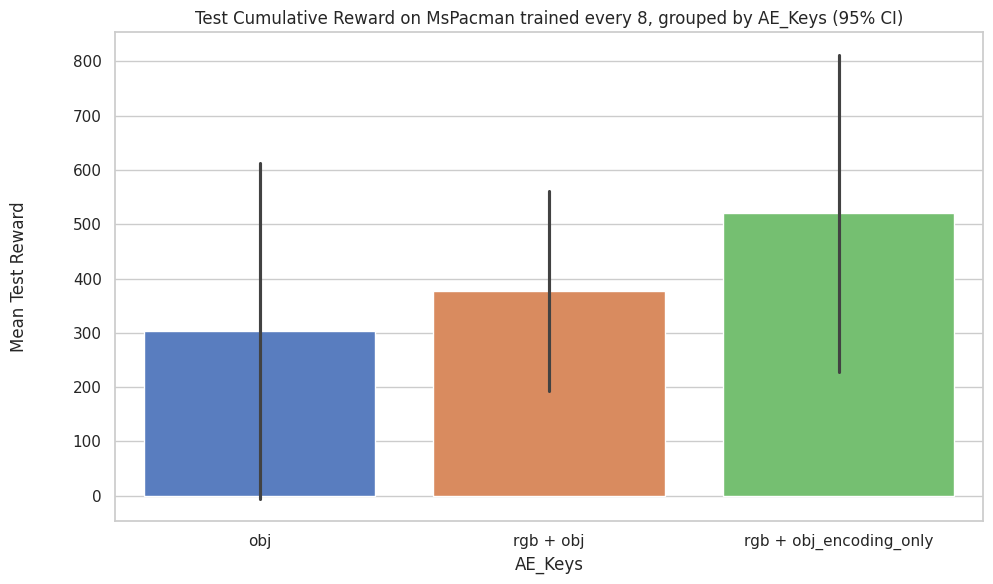

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64


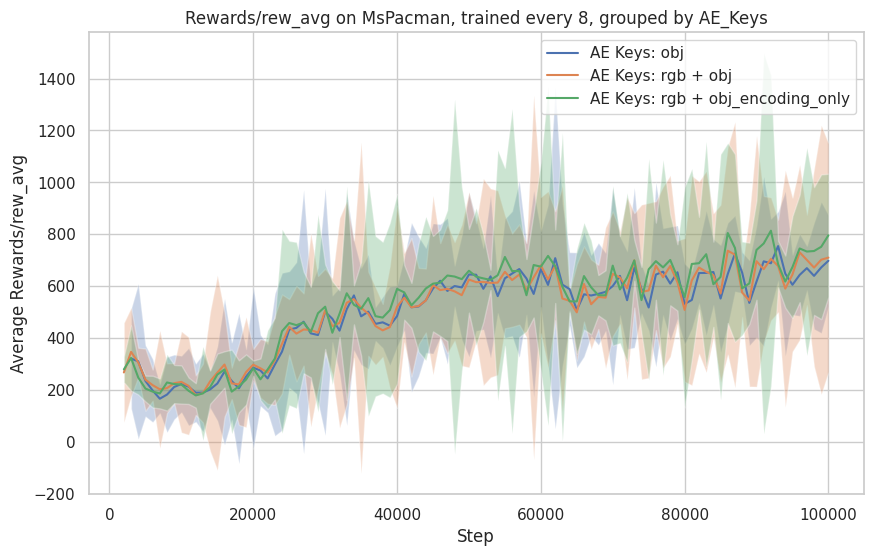

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj                        6
rgb + obj                  5
rgb + obj_encoding_only    5
Name: Run_ID, dtype: int64
Plotting for metric: Los

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

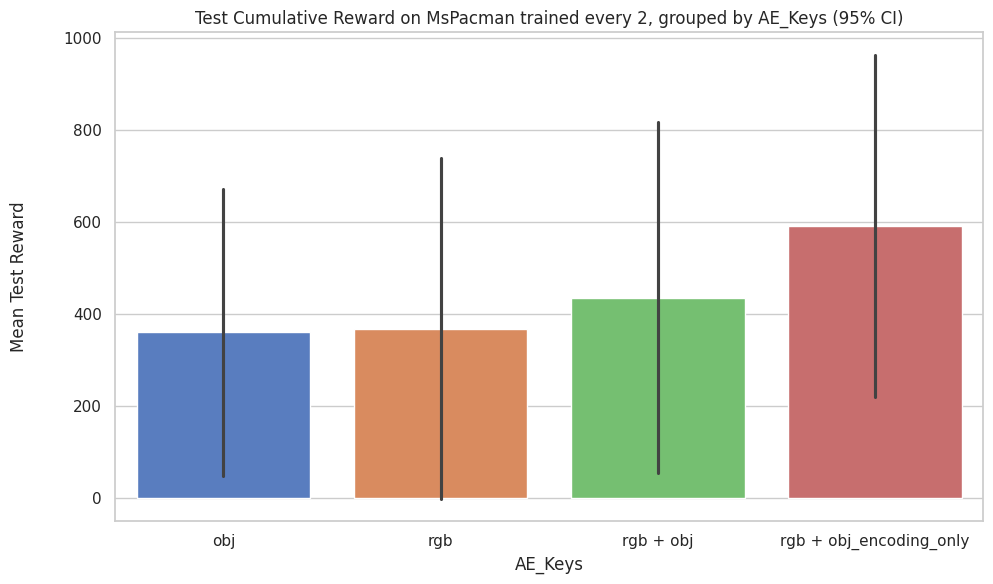

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64


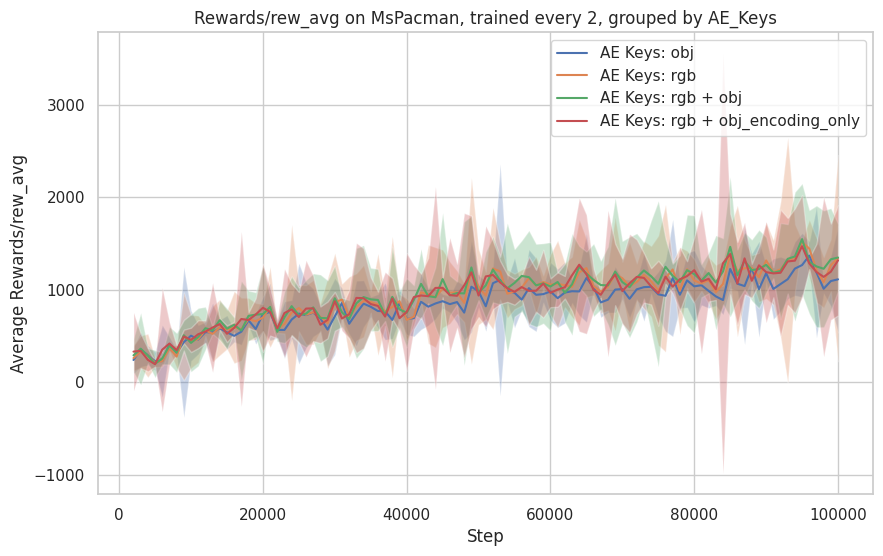

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
A

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

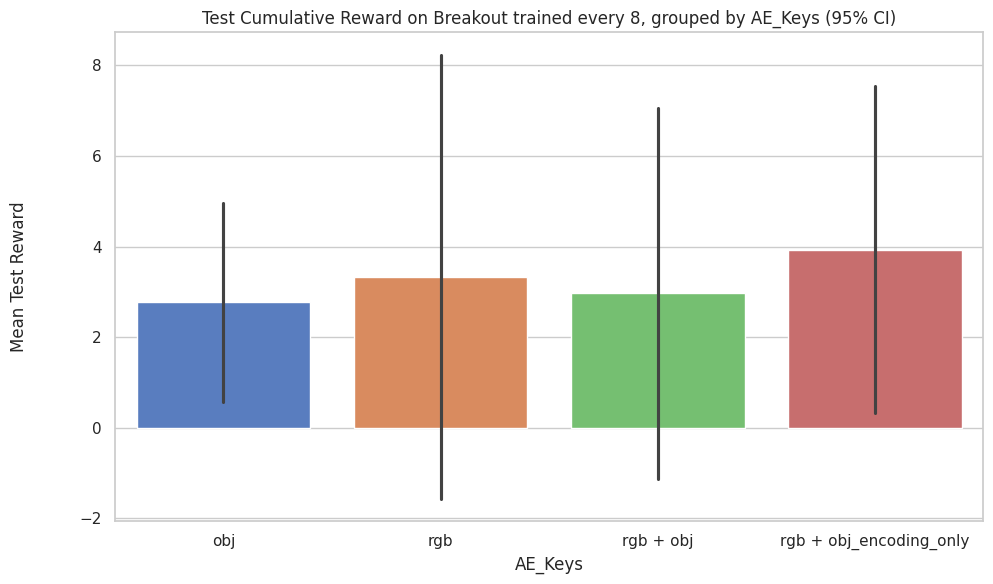

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64


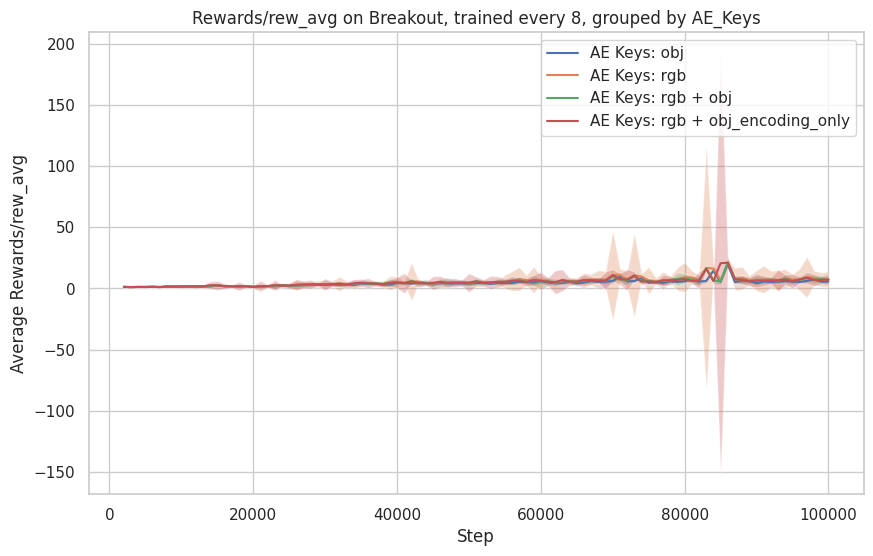

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                         5
rgb                         5
rgb + obj                  10
rgb + obj_encoding_only     5
Name: Run_ID, dtype: int64
Plotting for metric: Los

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

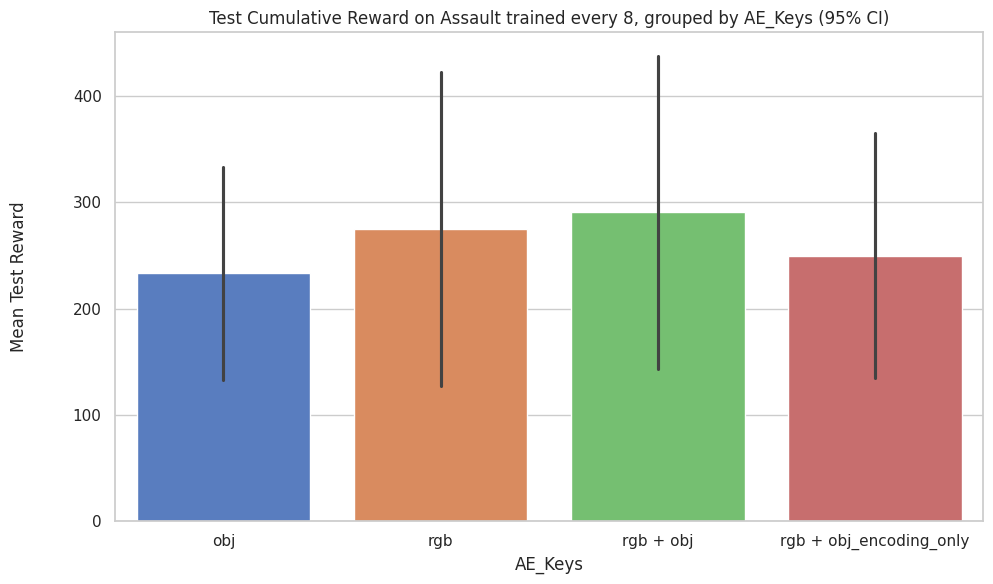

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64


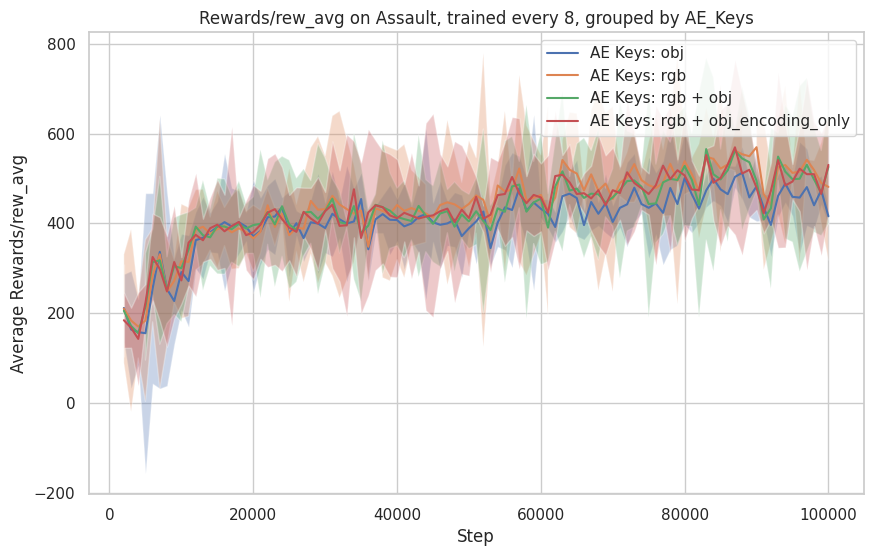

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
A

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

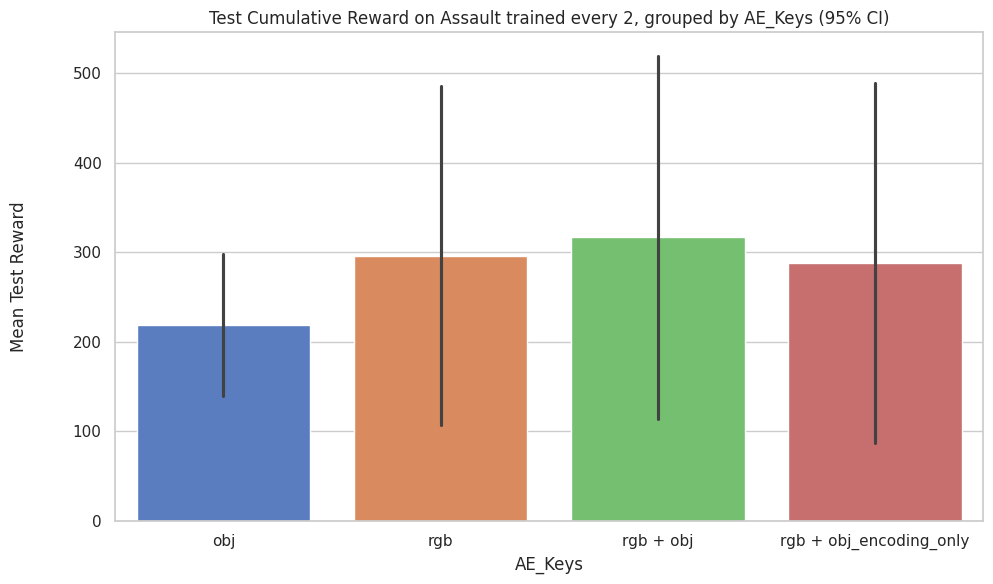

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64


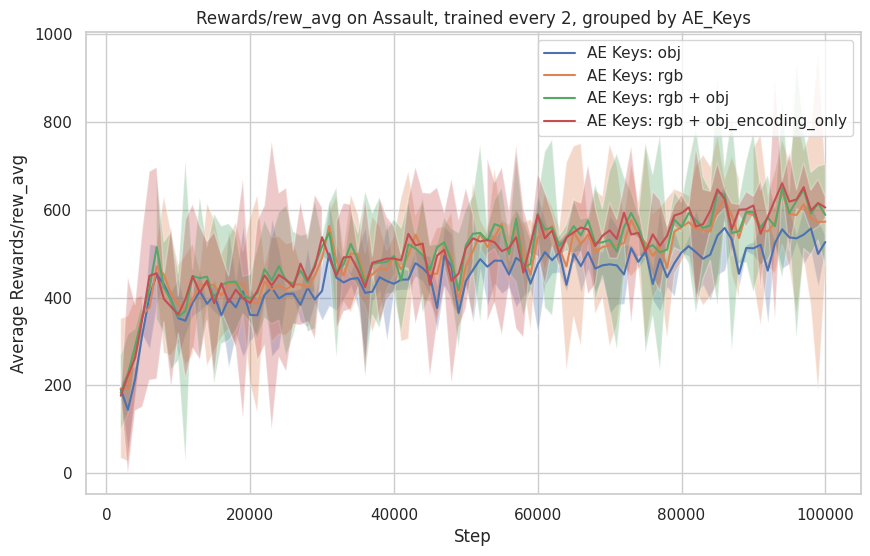

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                        2
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
A

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

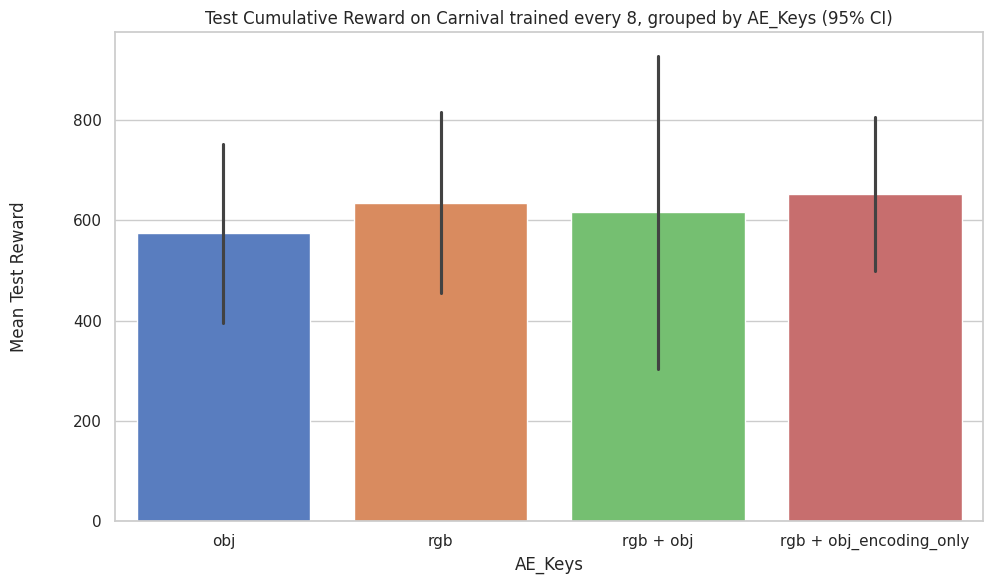

Plotting for metric: Rewards/rew_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64


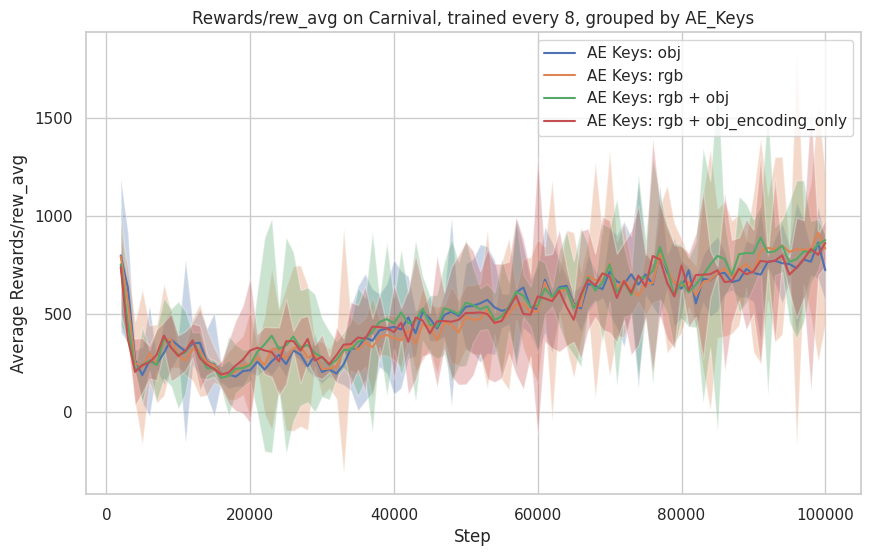

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                        3
rgb                        3
rgb + obj                  3
rgb + obj_encoding_only    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
A

In [58]:
games = ['MsPacman', 'Breakout', 'Assault', 'Carnival']

gpu_id = 0
do_test = False

for game in games:
    print(f"Processing {game}...")
    base_dir = f'logs/runs/dreamer_v3/{game}NoFrameskip-v4'
    update_viz(base_dir, gpu_id, do_test)

## Buffer 10K

In [35]:
all_experiments_df = process_all_experiments('logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4')

Total number of experiments processed: 195


Plotting for metric: Test/cumulative_reward
Buffer_Size
10000     3
100000    6
Name: Run_ID, dtype: int64
Plotting for metric: Rewards/rew_avg
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


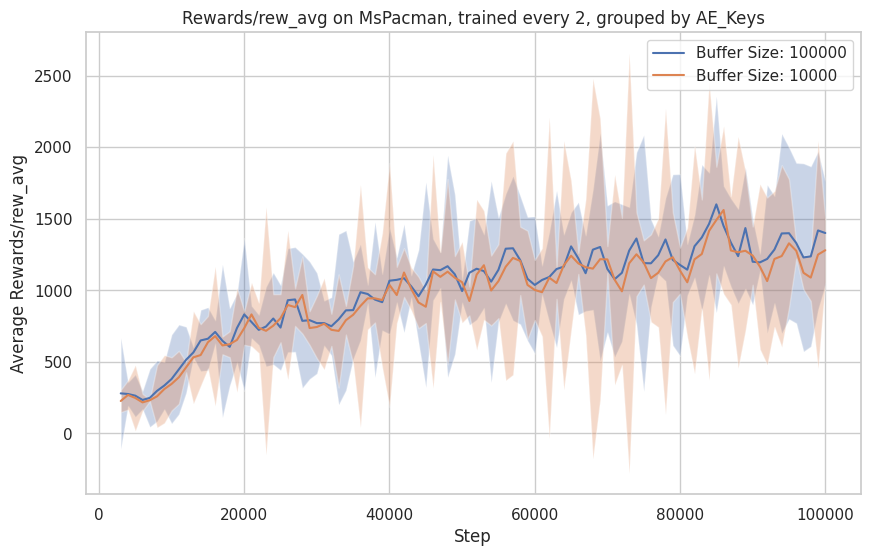

Plotting for metric: Game/ep_len_avg
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


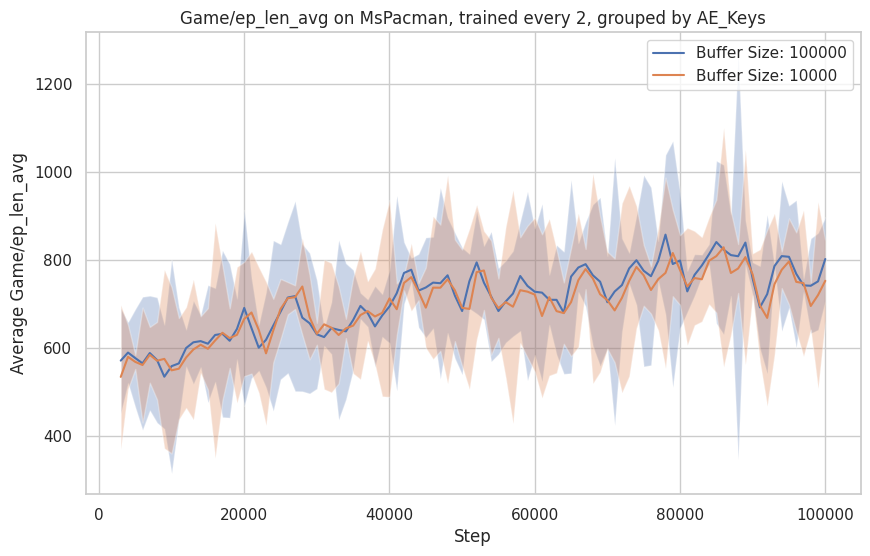

Plotting for metric: Time/sps_env_interaction
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


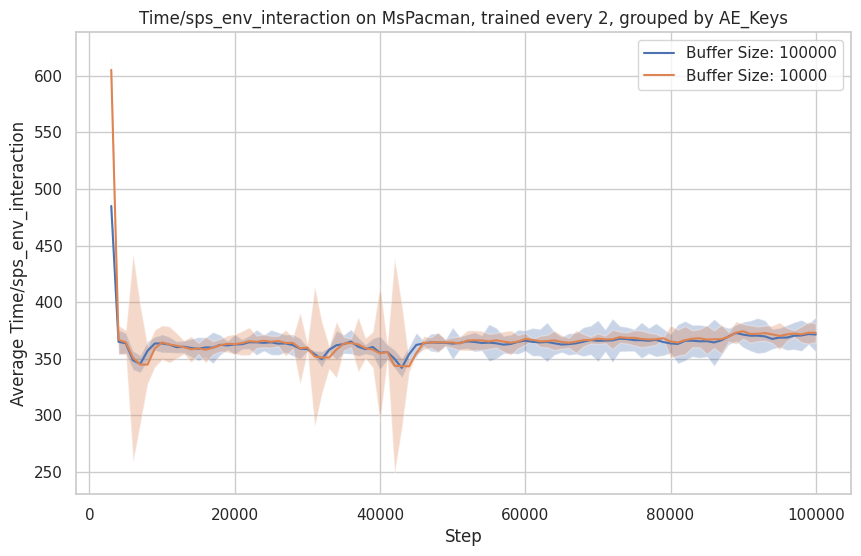

Plotting for metric: Loss/world_model_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


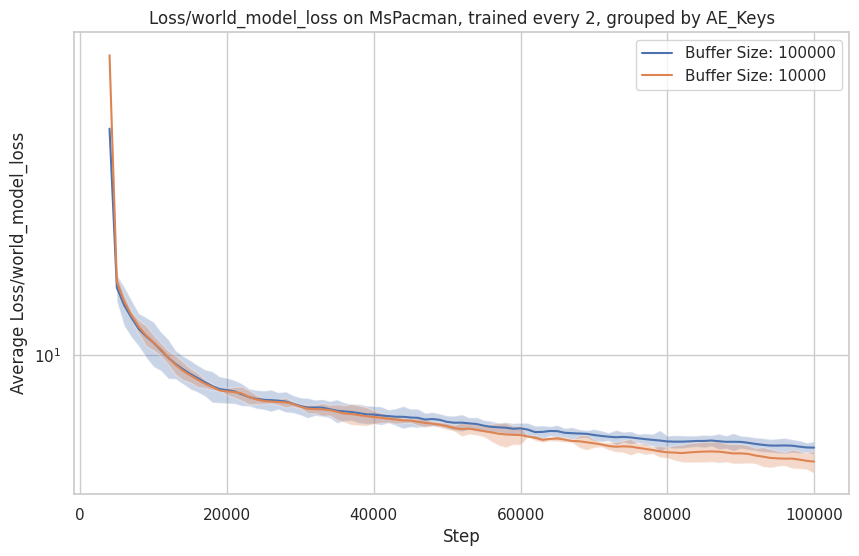

Plotting for metric: Loss/value_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


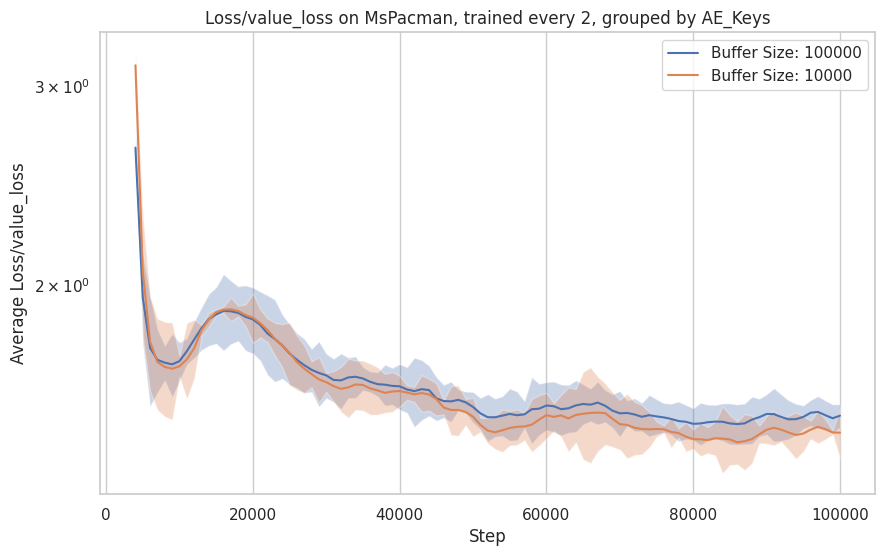

Plotting for metric: Loss/policy_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


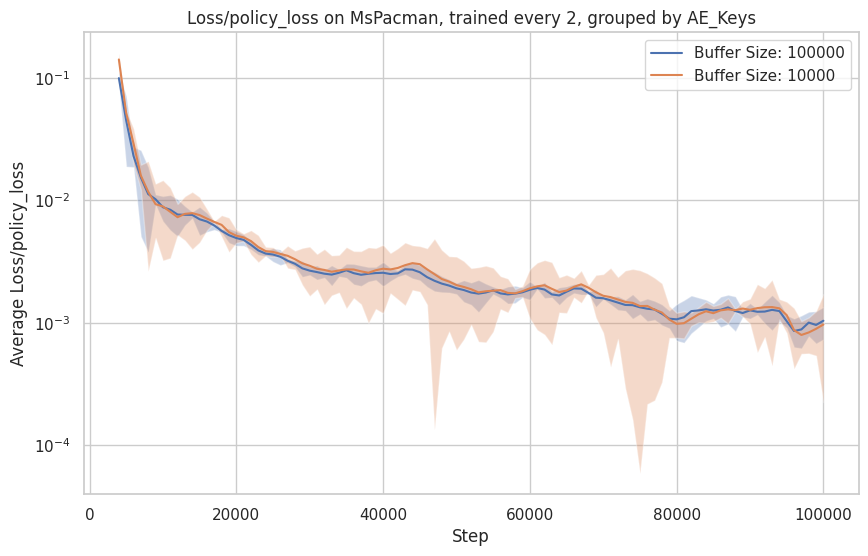

Plotting for metric: Loss/observation_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


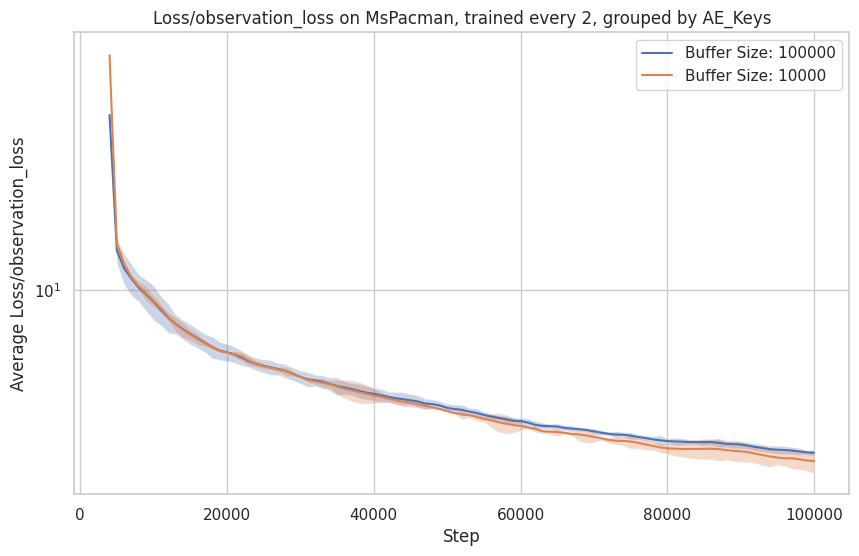

Plotting for metric: Loss/reward_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


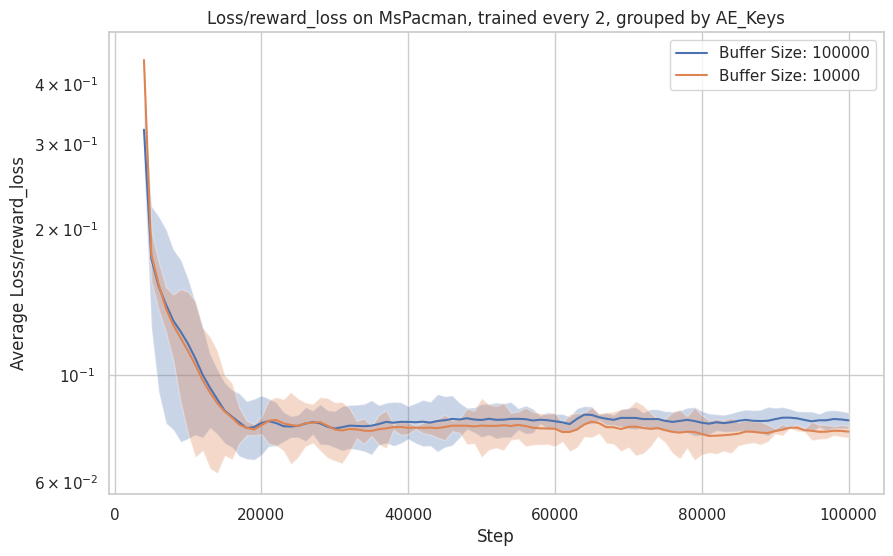

Plotting for metric: Loss/state_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


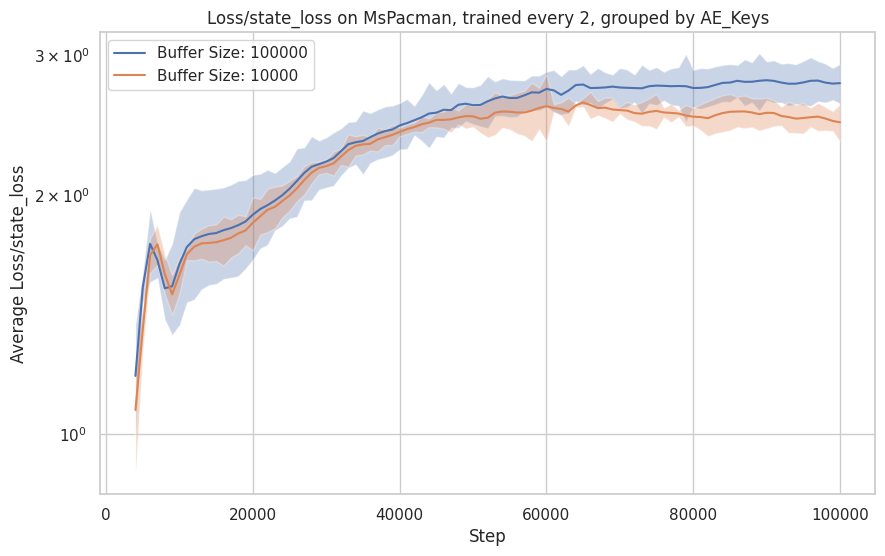

Plotting for metric: Loss/continue_loss
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


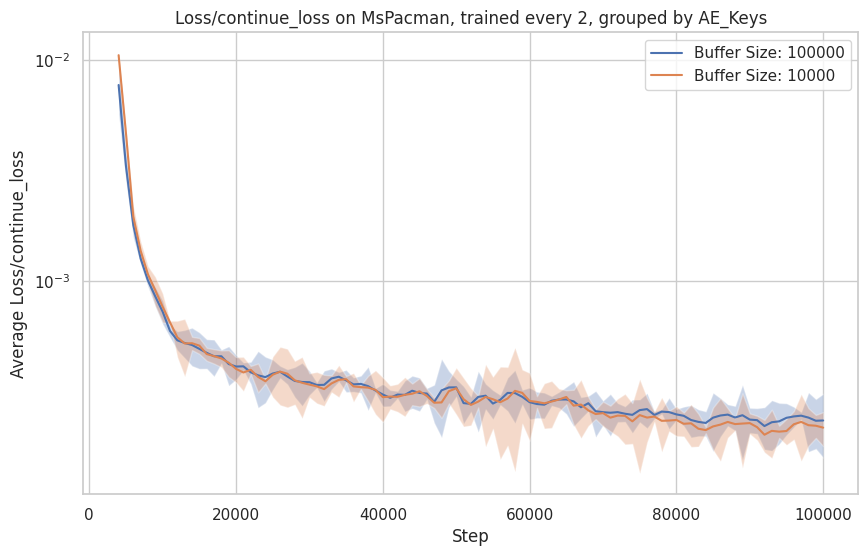

Plotting for metric: State/kl
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


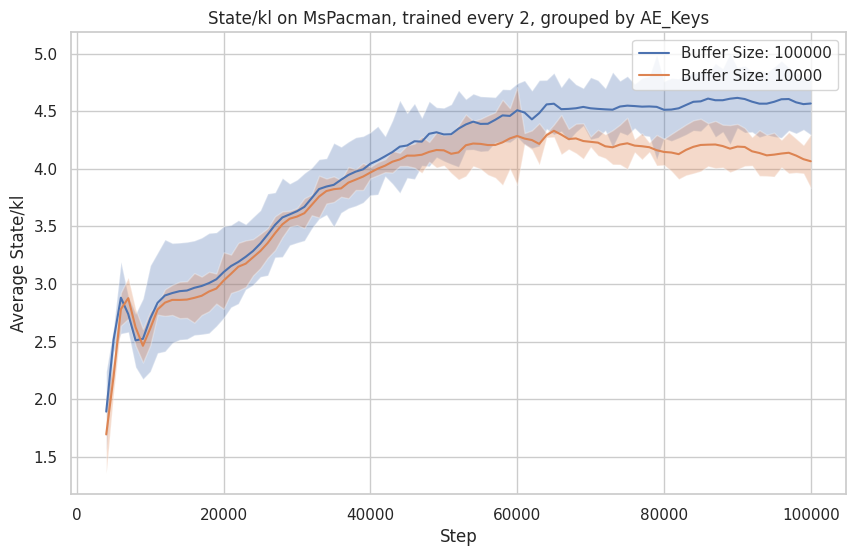

Plotting for metric: State/post_entropy
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


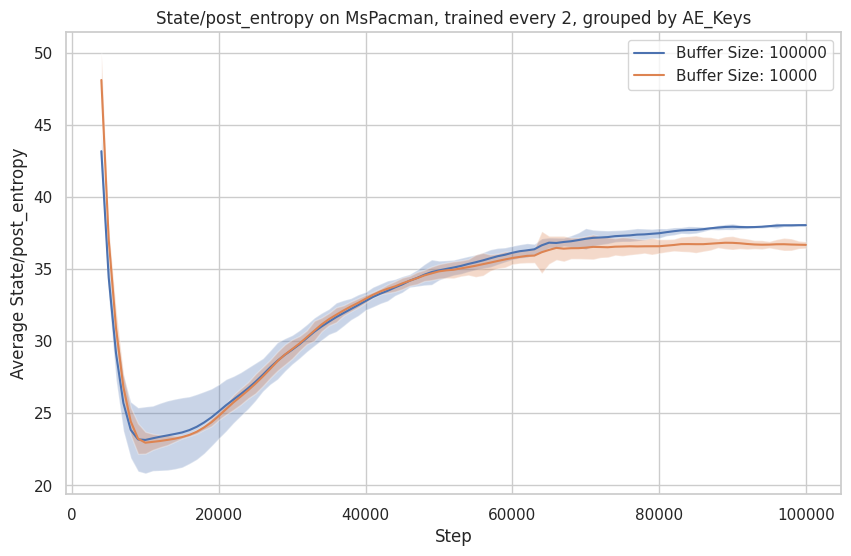

Plotting for metric: State/prior_entropy
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


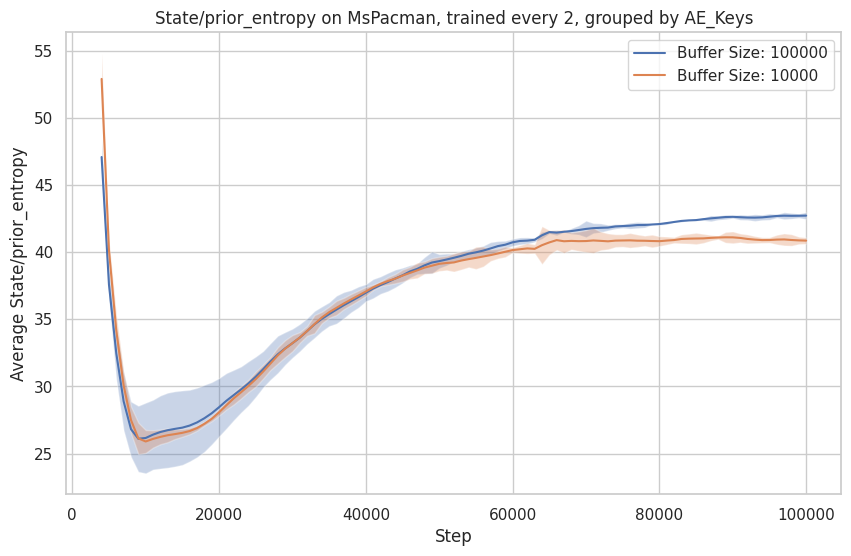

Plotting for metric: Grads/world_model
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


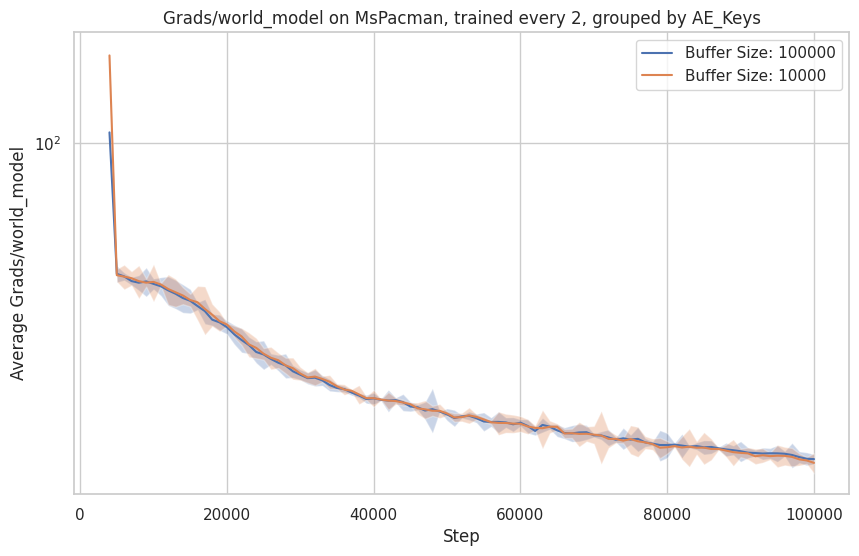

Plotting for metric: Grads/actor
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


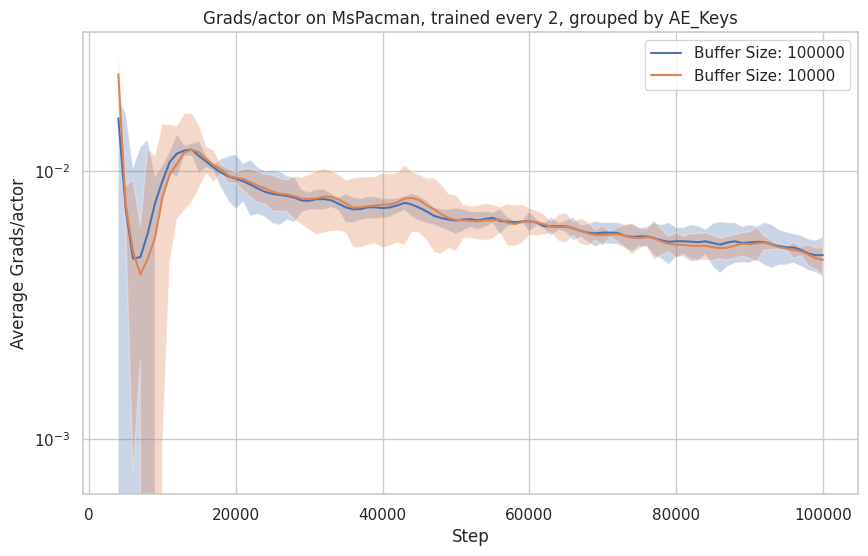

Plotting for metric: Grads/critic
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


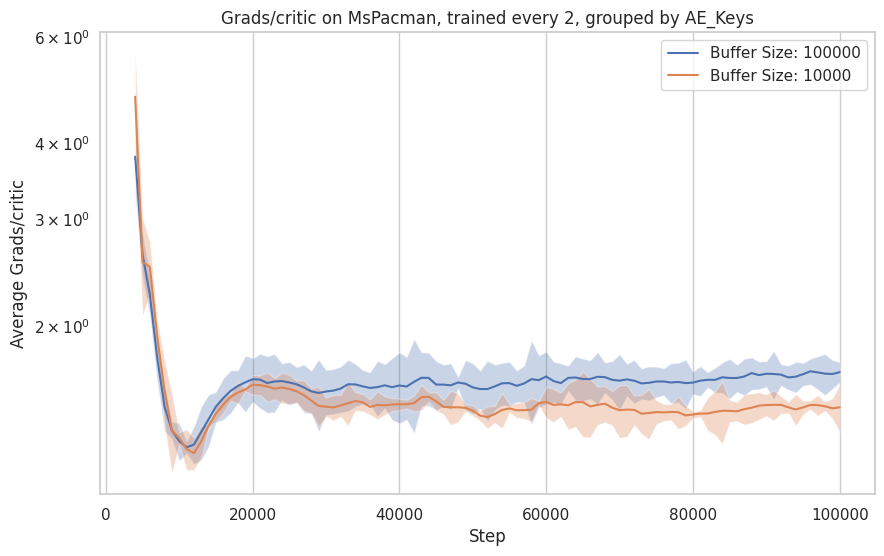

Plotting for metric: Loss/observation_loss_rgb
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


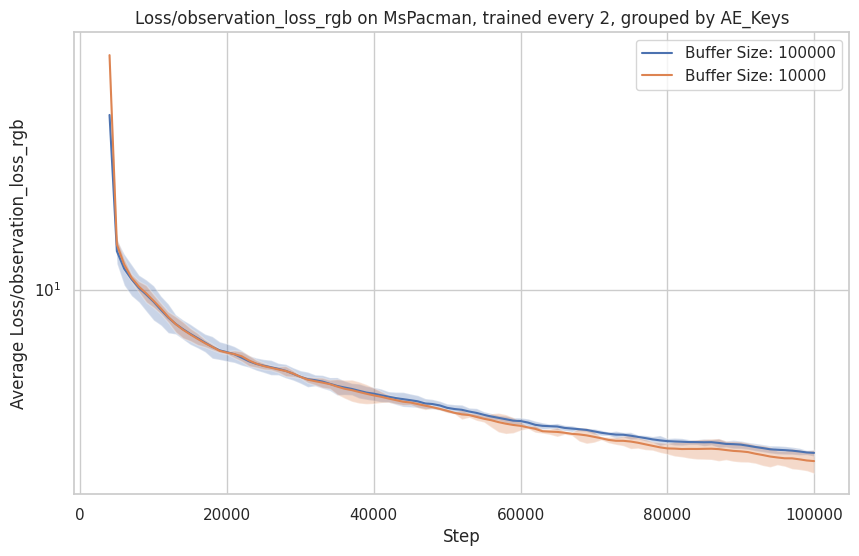

Plotting for metric: Loss/observation_loss_objects_position
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


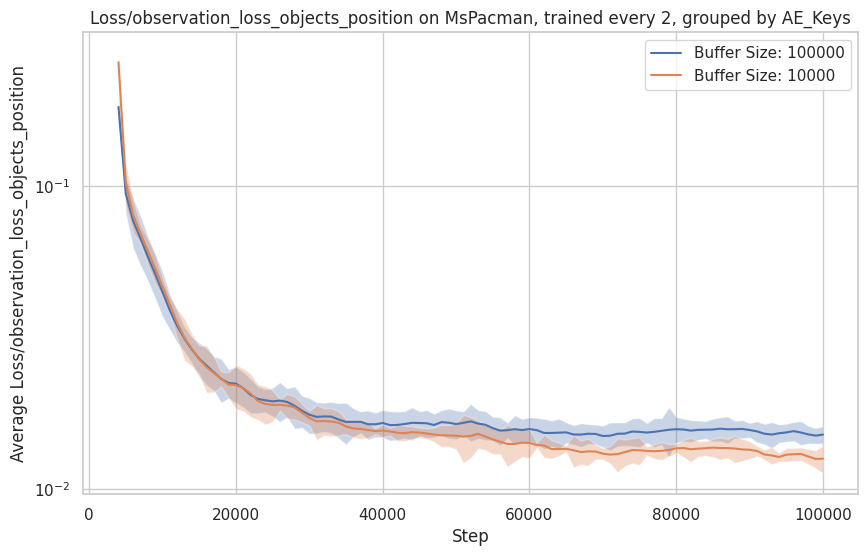

Plotting for metric: Time/sps_train
Buffer_Size
10000     3
100000    3
Name: Run_ID, dtype: int64


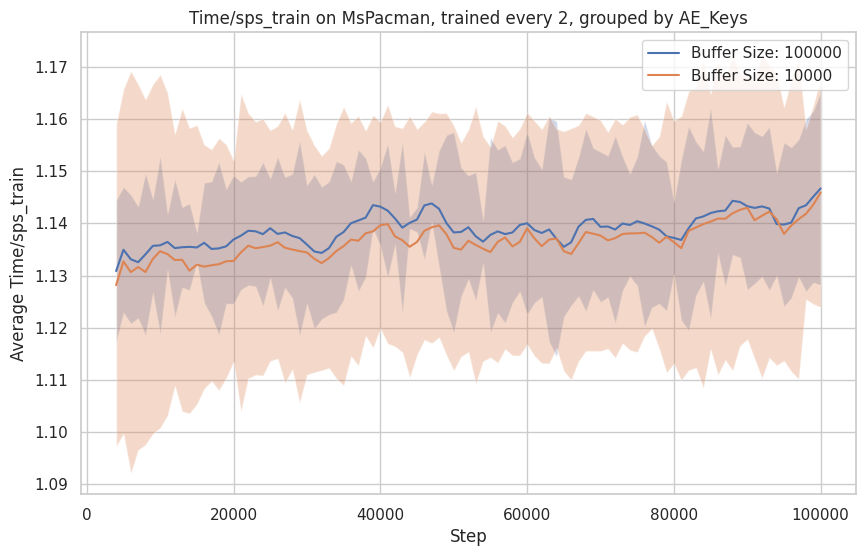

In [47]:
# unique runs by Buffer_Size, filter AE_Keys = obj_autoencoding and Train_Every=2
filtered_df = all_experiments_df[(all_experiments_df['AE_Keys'] == 'obj_autoencoding') & (all_experiments_df['Train_Every'] == 2)]
metrics = filtered_df['Metric'].unique()
for metric in metrics:
    if metric == 'hp_metric' or metric == 'Params/exploration_amount':
        continue
    print(f"Plotting for metric: {metric}")

    # Group by Step and Metric, then calculate mean and std
    metric_df = filtered_df[(filtered_df['Metric']==metric)]
    # get number of unique run ids by group of AE_Keys
    print(metric_df.groupby('Buffer_Size')['Run_ID'].nunique())
    grouped = metric_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed']).groupby(['Step', 'Buffer_Size'])
    mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
    # smoothing the plot
    mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
    #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


    # Plotting
    if metric == 'Test/cumulative_reward':
        continue

    plt.figure(figsize=(10, 6))
    # Unique AE_Keys
    buffer_unique = filtered_df['Buffer_Size'].unique()
    for buffer in buffer_unique:
        subset = mean_std_df[mean_std_df['Buffer_Size'] == buffer]
        
        # Plot mean
        plt.plot(subset['Step'], subset['mean'], label=f'Buffer Size: {buffer}')
        
        # Fill between mean ± std
        plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

    plt.title(f'{metric} on MsPacman, trained every 2, grouped by AE_Keys')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    # log scale for y-axis if metric contains "loss" or "grad"    
    if "Loss" in metric or "Grads" in metric:
        plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
metrics = df['Metric'].unique()
    train_every_list = df['Train_Every'].unique()
    print(f"Unique train_every: {train_every_list}")
    for train_every in train_every_list:
        if train_every not in [2, 8]:
            continue
        print(f"Plotting for train_every: {train_every}")
        for metric in metrics:
            if metric == 'hp_metric' or metric == 'Params/exploration_amount':
                continue
            print(f"Plotting for metric: {metric}")
            # Group by Step and Metric, then calculate mean and std
            filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000)]
            # get number of unique run ids by group of AE_Keys
            print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
            grouped = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed']).groupby(['Step', 'AE_Keys'])
            mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
            # smoothing the plot
            mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
            #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


            # Plotting
            plt.figure(figsize=(10, 6))

            # Unique AE_Keys
            ae_keys_unique = filtered_df['AE_Keys'].unique()

            for ae_key in ae_keys_unique:
                subset = mean_std_df[mean_std_df['AE_Keys'] == ae_key]
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'AE Keys: {ae_key}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

            plt.title(f'{metric} on {env_id.replace("NoFrameskip-v4", "")}, trained every {train_every}, grouped by AE_Keys')
            plt.xlabel('Step')
            plt.ylabel(f'Average {metric}')
            # log scale for y-axis if metric contains "loss" or "grad"    
            if "Loss" in metric or "Grads" in metric:
                plt.yscale('log')
            plt.legend()
            plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
            if metric == "Rewards/rew_avg":
                plt.show()
            else:
                plt.close()